In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


## Important

as first step run the notebook `1. classification-dataset-creation.ipynb` to create the dataset.

In [2]:
dataset_path = '../data/dataset-dirigenti-split.pkl'

with open(dataset_path, 'rb') as f:
    train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = pickle.load(f)

### Transform it in a dataset

In [3]:
train_samples[:5]

array([ 'RESIDUI PERENTI BILANCIO 1997 - IMPEGNO E LIQUIDAZIONE ALL ORDINE PROVINCIALE DEI MEDICI-CHIRURGHI E DEGLI ODONTOIATRI DI FIRENZE PERL ATTUAZIONE DI INIZIATIVE CULTURALI E SCIENTIFICHE DI SUPPORTO AI CORSI DI FORMAZIONE SPECIFICA IN MEDICINA GENERALE.',
       'L.R. 72/94 " Danni causati da animali predatori o da eventi meteorici al patrimonio zootecnico" - Liquidazione indennizzi beneficiari Euro 34.988,28=.',
       'Eventi alluvionali novembre 2000 - Interventi urgenti connessi alla difesa idraulica - Erogazione al Comune di Montemurlo (PO) saldo finanziamento spettante per realizzazione intervento n. 301 compreso nel Piano regionale di cui all`allegato 2 della DGRT n. 104/2003.',
       'APPROVAZIONE SCHEMA DI CONVENZIONE TRA LA REGIONE TOSCANA E I SOGGETTI PRIVATI AMMESSI A CONTRIBUTO PER I PROGETTI-INTERVENTO IN MATERIA DI PAESAGGIO',
       'Contributo al Comune di Siena per l`organizzazione della Terza giornata del Contemporaneo in programma nel mese di ottobre 2007.']

In [4]:
train_labels[:5]

array(['01943', '01934',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT'],
      dtype='<U54')

In [5]:
samples = np.concatenate([train_samples,val_samples, test_samples])
samples.shape

(138043,)

In [6]:
labels = np.concatenate([train_labels, val_labels, test_labels])
labels.shape

(138043,)

## Tokenize the Dataset

In [7]:
from keras.preprocessing.text import Tokenizer

In [8]:
num_words = 10000

In [9]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(samples)

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_samples)
val_sequences = tokenizer.texts_to_sequences(val_samples)
test_sequences = tokenizer.texts_to_sequences(test_samples)

In [11]:
for s in train_sequences[:2]:
    print(s)

[1120, 915, 418, 721, 14, 2, 18, 50, 2055, 530, 21, 1072, 2, 52, 1, 66, 179, 1, 691, 749, 2, 5399, 1, 512, 25, 723, 1, 129, 1100, 10, 558, 321]
[7, 6, 956, 88, 740, 2101, 45, 1187, 3733, 132, 45, 277, 4270, 13, 313, 1613, 18, 2539, 965, 221, 708, 7629, 298]


Convert labels to sequences

In [12]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [13]:
labels[:10]

array(['01943', '01934',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI',
       'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT',
       'D.G.  AVVOCATURA                                      ',
       'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI',
       'DIREZIONE ISTRUZIONE E FORMAZIONE',
       'DIREZIONE GENERALE BILANCIO E FINANZE                 ',
       "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D"],
      dtype='<U54')

In [14]:
print(labels_to_index)
print(len(labels_to_index))

{'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 0, '01928': 1, 'DIREZIONE ORGANIZZAZIONE E SISTEMI INFORMATIVI': 2, 'DIREZIONE GENERALE DIRITTO ALLA SALUTE E POLITICHE DI ': 3, '01934': 4, 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 5, '01937': 6, 'DIREZIONE GENERALE BILANCIO E FINANZE                 ': 7, 'DIREZIONE ISTRUZIONE E FORMAZIONE': 8, 'DIREZIONE GENERALE POLITICHE FORMATIVE, BENI E ATTIVIT': 9, "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 10, 'D.G. PRESIDENZA                                       ': 11, 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 12, '01025': 13, '01946': 14, 'D.G.  AVVOCATURA                                      ': 15, 'DIREZIONE GENERALE SVILUPPO ECONOMICO                 ': 16, 'POLITICHE AMBIENTALI, ENERGIA E CAMBIAMENTI CLIMATICI': 17, 'DIREZIONE GENERALE POLITICHE TERRITORIALI E AMBIENTALI': 18, '01943': 19}
20


In [15]:
encoded_train_labels = [labels_to_index[l] for l in train_labels]
encoded_val_labels = [labels_to_index[l] for l in val_labels]
encoded_test_labels = [labels_to_index[l] for l in test_labels]

In [16]:
encoded_train_labels[:10]

[19, 4, 18, 18, 9, 15, 2, 8, 7, 10]

### Preparing Data

for data and labels

In [17]:
from keras.preprocessing import text

In [18]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [19]:
x_train = vectorize_sequences(train_sequences, num_words)
x_val = vectorize_sequences(val_sequences, num_words)
x_test = vectorize_sequences(test_sequences, num_words)

In [20]:
x_train[0:]

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [21]:
x_train.shape

(99390, 10000)

One hot encoding for the labels

In [22]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float16)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [23]:
y_train = to_one_hot(encoded_train_labels)
y_val = to_one_hot(encoded_val_labels)
y_test = to_one_hot(encoded_test_labels)

In [24]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float16)

## Build the Models

In [25]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [26]:
model_small = build_model(16)
history_small = model_small.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)



Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 4s 36us/step - loss: 1.5784 - acc: 0.5326 - val_loss: 0.8274 - val_acc: 0.7377
Epoch 2/10
99390/99390 [==============================] - 2s 21us/step - loss: 0.6835 - acc: 0.7777 - val_loss: 0.6513 - val_acc: 0.7824
Epoch 3/10
99390/99390 [==============================] - 2s 22us/step - loss: 0.5318 - acc: 0.8240 - val_loss: 0.5965 - val_acc: 0.8035
Epoch 4/10
99390/99390 [==============================] - 2s 22us/step - loss: 0.4511 - acc: 0.8477 - val_loss: 0.5851 - val_acc: 0.8077
Epoch 5/10
99390/99390 [==============================] - 2s 23us/step - loss: 0.3989 - acc: 0.8646 - val_loss: 0.5777 - val_acc: 0.8137
Epoch 6/10
99390/99390 [==============================] - 2s 22us/step - loss: 0.3585 - acc: 0.8786 - val_loss: 0.5848 - val_acc: 0.8158
Epoch 7/10
99390/99390 [==============================] - 2s 22us/step - loss: 0.3274 - acc: 0.8884 - val_loss: 0.5943 - val_acc

In [27]:
model_medium = build_model(64)
history_medium = model_medium.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 3s 28us/step - loss: 1.0509 - acc: 0.6732 - val_loss: 0.5707 - val_acc: 0.8076
Epoch 2/10
99390/99390 [==============================] - 3s 26us/step - loss: 0.4548 - acc: 0.8461 - val_loss: 0.5035 - val_acc: 0.8262
Epoch 3/10
99390/99390 [==============================] - 3s 25us/step - loss: 0.3443 - acc: 0.8802 - val_loss: 0.5053 - val_acc: 0.8323
Epoch 4/10
99390/99390 [==============================] - 2s 25us/step - loss: 0.2792 - acc: 0.9013 - val_loss: 0.5294 - val_acc: 0.8291
Epoch 5/10
99390/99390 [==============================] - 2s 25us/step - loss: 0.2343 - acc: 0.9172 - val_loss: 0.5380 - val_acc: 0.8348
Epoch 6/10
99390/99390 [==============================] - 3s 25us/step - loss: 0.1973 - acc: 0.9312 - val_loss: 0.5756 - val_acc: 0.8313
Epoch 7/10
99390/99390 [==============================] - 2s 25us/step - loss: 0.1691 - acc: 0.9421 - val_loss: 0.6198 - val_acc

In [28]:
model_large = build_model(256)
history_large = model_large.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                   epochs=10, batch_size=256)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 5s 48us/step - loss: 0.8307 - acc: 0.7313 - val_loss: 0.5110 - val_acc: 0.8218
Epoch 2/10
99390/99390 [==============================] - 5s 47us/step - loss: 0.3568 - acc: 0.8738 - val_loss: 0.4717 - val_acc: 0.8378
Epoch 3/10
99390/99390 [==============================] - 4s 43us/step - loss: 0.2268 - acc: 0.9193 - val_loss: 0.4888 - val_acc: 0.8447
Epoch 4/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.1522 - acc: 0.9463 - val_loss: 0.5062 - val_acc: 0.8489
Epoch 5/10
99390/99390 [==============================] - 4s 42us/step - loss: 0.1083 - acc: 0.9626 - val_loss: 0.5751 - val_acc: 0.8461
Epoch 6/10
99390/99390 [==============================] - 4s 43us/step - loss: 0.0878 - acc: 0.9704 - val_loss: 0.5833 - val_acc: 0.8496
Epoch 7/10
99390/99390 [==============================] - 4s 43us/step - loss: 0.0687 - acc: 0.9772 - val_loss: 0.6463 - val_acc

### Printing The Loss

In [29]:
import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,2.25,0.25))
    plt.legend()
    plt.show()

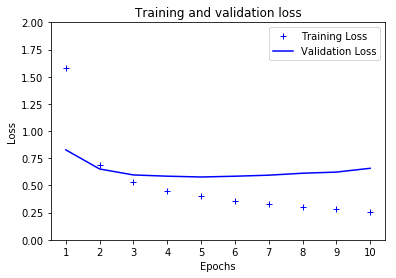

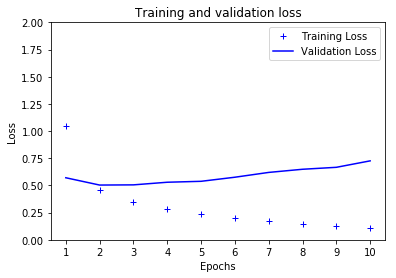

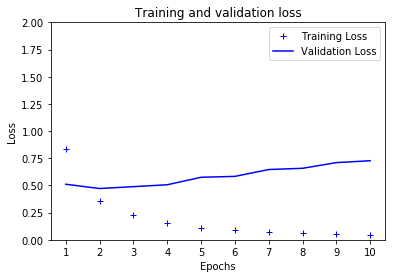

In [31]:
chart_loss(history_small)
chart_loss(history_medium)
chart_loss(history_large)

In [32]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.xticks(epochs)
    plt.yticks(np.arange(0,1.1,0.1))
    plt.legend()
    plt.show()

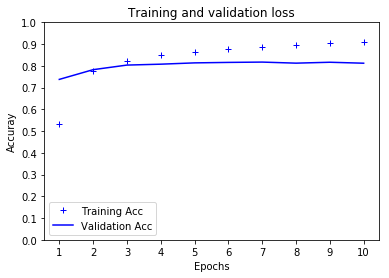

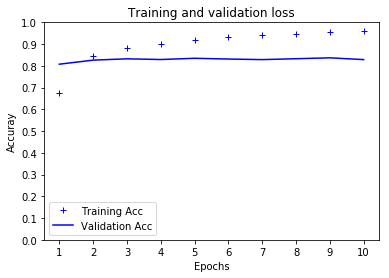

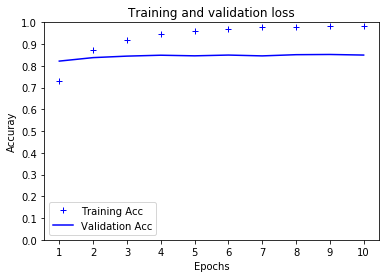

In [33]:
chart_acc(history_small)
chart_acc(history_medium)
chart_acc(history_large)

In [34]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

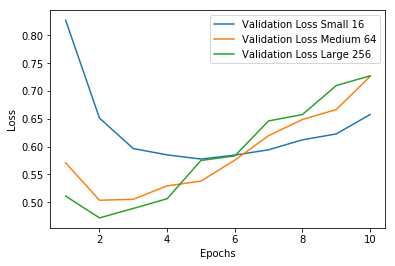

In [35]:
compare_loss({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

In [36]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

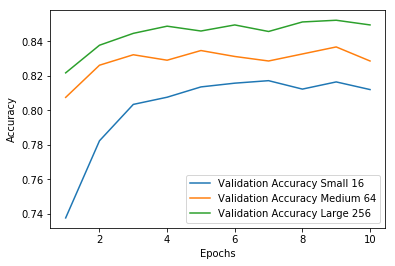

In [37]:
compare_accuracy({'Small 16': history_small, 'Medium 64': history_medium, 'Large 256': history_large})

In [ ]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

In [ ]:
print('min loss for model small is {}'.format(min_loss(history_small)))
print('min loss for model medium is {}'.format(min_loss(history_medium)))
print('min loss for model large is {}'.format(min_loss(history_large)))

In [ ]:
print('best validation accuracy for model small is {}'.format(
    accuracy(history_small, min_loss(history_small))))
print('best validation accuracy for model medium is {}'.format(
    accuracy(history_medium, min_loss(history_medium))))
print('best validation accuracy for model large is {}'.format(
    accuracy(history_medium, min_loss(history_medium))))

### Evaluate on the Test Set

- train the best model for the best epochs

In [54]:
import gc

In [55]:
gc.collect()

785

In [56]:
model = build_model(256)

In [57]:
history = model.fit(x=np.concatenate([x_train, x_val]), y=np.concatenate([y_train, y_val]), epochs=2, batch_size=256)

Epoch 1/2
110434/110434 [==============================] - 5s 46us/step - loss: 0.7956 - acc: 0.7421
Epoch 2/2
110434/110434 [==============================] - 5s 42us/step - loss: 0.3481 - acc: 0.8767


In [58]:
loss, acc = model.evaluate(x_test, y_test)

27609/27609 [==============================] - 1s 46us/step


In [59]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.4618098787730501
acc 0.8412111992725291
